# MVTec compare

I intend to compare the results from the original paper with the ones I obtained on the dataset MVTec-AD.

I also aggregated the training time measurement here.

Let's first check that I have all the runs. 

In [1]:
# setup

# make a cell print all the outputs instead of just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path

In [2]:
%pwd

'/home/bertoldo/repos/fcdd/python/analyse'

In [3]:
%ls ../../data/results | grep mvtec

fcdd_20211220174145_mvtec_/
fcdd_20211221161817_mvtec_/
fcdd_20211221161817_mvtec_.bkp/
fcdd_20211221161817_mvtec_.pt1@
fcdd_20211221161817_mvtec_.pt2/
fcdd_20211222095442_mvtec_/
fcdd_20211223154029_mvtec_/
fcdd_20211223165734_mvtec_/
fcdd_20211223171505_mvtec_/
fcdd_20220119145705_unsup_pt3_mvtec_/
fcdd_20220121004711_sup_pt3_mvtec_/
mvtec/


Because the experiments were cut due to issues in the machine, they are split in several folders, so I "merged" them by creating symbolic links.

In [4]:
%ls ../../data/results/mvtec/

incomplete/  supervised_merged/  unsupervised_merged/


In [5]:
%ls ../../data/results/mvtec/unsupervised_merged/

normal_0@   normal_11@  normal_14@  normal_4@  normal_7@
normal_1@   normal_12@  normal_2@   normal_5@  normal_8@
normal_10@  normal_13@  normal_3@   normal_6@  normal_9@


In [6]:
%ls ../../data/results/mvtec/supervised_merged/

normal_0@   normal_11@  normal_14@  normal_4@  normal_7@
normal_1@   normal_12@  normal_2@   normal_5@  normal_8@
normal_10@  normal_13@  normal_3@   normal_6@  normal_9@


In [7]:
%ls ../../data/results/mvtec/supervised_merged/normal_0/it_0/

config.txt           heatmaps_paper_global_lbl0.png  roc_curve.pdf
ds_preview.png       heatmaps_paper_global_lbl1.png  roc.json
err_anomalous.pdf    heatmaps_paper_local_lbl0.png   snapshot.pt
err_normal.pdf       heatmaps_paper_local_lbl1.png   src.tar.gz
err.pdf              history.json                    tims/
gtmap_roc_curve.pdf  log.txt                         train_heatmaps_global.png
heatmaps_global.png  print.log


## funcs

In [8]:
import numpy as np
from numpy import ndarray
from typing import Dict, Union
from pathlib import Path
import json
import re
from datetime import timedelta, datetime
import numpy as np
from numpy import ndarray
from typing import Dict, Union
from pathlib import Path
import json
import numpy as np
from numpy import ndarray
from typing import Dict, Union
from pathlib import Path
import json
import re
import copy
from typing import List


# this is to get the strings associated to the classes in the fcdd code
# copied from: fcdd/python/fcdd/datasets/__init__.py
# inside function `str_labels`
# commit: 9f268d8fd2fee33a5c5f38cdfb781da927bdb614
CLASS_LABELS = {
    'cifar10': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
    'fmnist': [
        't-shirt/top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
    ],
    'mvtec': [
        'bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather',
        'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor',
        'wood', 'zipper'
    ],
    # 'imagenet': deepcopy(ADImageNet.ad_classes),
    # this one forwards to: fcdd/python/fcdd/datasets/imagenet.py
    # in: ADImageNet.ad_classes
    # at the same commit as above
    'imagenet': ['acorn', 'airliner', 'ambulance', 'American alligator', 'banjo', 'barn', 'bikini', 'digital clock',
                  'dragonfly', 'dumbbell', 'forklift', 'goblet', 'grand piano', 'hotdog', 'hourglass', 'manhole cover',
                  'mosque', 'nail', 'parking meter', 'pillow', 'revolver', 'dial telephone', 'schooner',
                  'snowmobile', 'soccer ball', 'stingray', 'strawberry', 'tank', 'toaster', 'volcano'],
    'pascalvoc': ['horse'],
}


def get_classes_labels_order(dataset: str) -> List[str]:
    return copy.deepcopy(CLASS_LABELS[dataset])


def get_class_label(class_dirname: str, dataset: str) -> str:
    return CLASS_LABELS[dataset][int(class_dirname.lstrip("normal_"))]


def get_training_time(path: Path) -> Dict[str, float]:
    """
    The is printed in `log.txt` as 
        START: 21-12-2021 22:46:18 
        DURATION: 1:13:29.009893 
    so this function parses that file.
    
    :param path: points to the 'log.txt' file inside an experiment (dataset + class + iteration)
    
    # simple test
    TEST_PATH = Path("../../data/results/mvtec/supervised_merged/normal_0/it_0/log.txt")
    get_training_time(TEST_PATH)
    del TEST_PATH
    """
    DURATION_LINE_REGEX = r"^DURATION: (.+) $"
    DELTA_DATETIME_FORMAT = "%H:%M:%S.%f"
    
    # src: https://stackoverflow.com/a/1327389/9582881
    search = re.search(DURATION_LINE_REGEX, path.read_text(), re.MULTILINE)
    assert search is not None
    delta_str = search.group(1)
    assert delta_str != ""
    # src: https://stackoverflow.com/a/12352624/9582881
    t = datetime.strptime(delta_str, DELTA_DATETIME_FORMAT)
    delta = timedelta(hours=t.hour, minutes=t.minute, seconds=t.second)
    assert delta > timedelta(0)
    return {"training_timedelta": delta}


def get_roc(path: Path) -> Dict[str, Union[float, ndarray]]:
    """
    :param path: points to the 'roc.json' file inside an experiment (dataset + class + iteration)
    """
    ROC_JSON_EXPECTED_KEYS = {"tpr", "fpr", "ths", "auc"}
    ROC_JSON_LISTS = {"tpr", "fpr", "ths"}
    
    with path.open("r") as json_file:
        payload = json.load(json_file)
    
    assert type(payload) == dict, f"{type(payload)=}"
    assert set(payload.keys()) == ROC_JSON_EXPECTED_KEYS, f"{set(payload.keys())=}"
    
    # transform the lists in ndarrays
    for list_key in ROC_JSON_LISTS:
        list_obj = payload[list_key]
        assert type(list_obj) == list, f"{type(list_obj)=}"
        payload[list_key] = np.array(list_obj)
        
    return payload


def get_pixelwise_roc(path: Path) -> Dict[str, float]:
    """
    The pixel-wise roc is often lost in mvtec because the images are big so the json
    with all the tpr/fpr/ths would be too big (there's a limit of 10MB somewhere in the code)
    but the pixel-wise ROC-AUC is printed in `log.txt` as like
    ##### GTMAP ROC TEST SCORE 0.9562439079836628 #####
    so this function parses that file.
    
    :param path: points to the 'log.txt' file inside an experiment (dataset + class + iteration)
    """
    # "gtmap" = "pixel-wise" here
    # i got the floating point pattern in stackoverflow
    # src: https://stackoverflow.com/a/12643073/9582881
    GTMAP_ROC_LINE_REGEX = r"##### GTMAP ROC TEST SCORE (([0-9]*[.])?[0-9]+) #####"
    
    # src: https://stackoverflow.com/a/1327389/9582881
    search = re.search(GTMAP_ROC_LINE_REGEX, path.read_text())
    assert search is not None
    val = float(search.group(1))
    assert 1 >= val >= 0
    return {"auc": val}


def experiment_key(experiment_dir: Path) -> str:
    """
    :param experiment_dir: path to the experiment directory
    """
    return f"{experiment_dir.parent.name}.{experiment_dir.name}"


def build_experiment_payload(experiment_dir: Path, dataset: str) -> Dict[str, Union[str, float, ndarray]]:
    """
    :param experiment_dir: path to the experiment directory
    """
    normal_class_str = experiment_dir.parent.name
    roc_json_path = experiment_dir / "roc.json"
    pixelwise_roc_pdf_path = experiment_dir / "gtmap_roc_curve.pdf"
    print_log_path = experiment_dir / "print.log"
    log_txt_path = experiment_dir / "log.txt"
    
    return {
        "normal_class": normal_class_str,
        "it": experiment_dir.name,
        "dir": experiment_dir,
        "roc_json_path": roc_json_path,
        "normal_class_label": get_class_label(normal_class_str, dataset),
        **get_training_time(log_txt_path),
        **{
            # this is a renaming so sample_roc/pixel_roc won't conflict
            f"sample_roc.{key}": val 
            for key, val in get_roc(roc_json_path).items()
        },
        **(
            {
                f"pixel_roc.{key}": val 
                for key, val in get_pixelwise_roc(print_log_path).items()
            }
            if pixelwise_roc_pdf_path.exists() else
            {}
        )
    }


def get_all_rocs_experiment(path: Path, dataset: str) -> Dict[str, Dict[str, Union[str, float, ndarray]]]:
    
    """
    :param path: a folder that looks like 'fcdd_20211220193242_fmnist_' 
                 a whole experiment on a dataset with all iterations and nominal classes inside, 
                 the structure should look like
                 
                path/
                path/normal_0
                path/normal_1
                ...
                path/normal_9/
                path/normal_9/it_0
                ...
                path/normal_9/it_4/roc.json
    """
    assert path.is_dir()
    assert dataset in CLASS_LABELS
    
    experiments = {
        (key := experiment_key(iterpath)): {
            **build_experiment_payload(iterpath, dataset=dataset),
            **{"key": key},
        }
        
        # first level: classes
        for dirpath in path.glob("normal_*")
        if dirpath.is_dir()
        
        # second level: iterations
        for iterpath in dirpath.glob("it_*")
        if iterpath.is_dir()
    }
    
    return experiments


# some simple tests
TEST_PATH = Path("../../data/results/mvtec/supervised_merged/normal_0/it_0")
build_experiment_payload(TEST_PATH, dataset="mvtec")
del TEST_PATH

TEST_PATH = Path("../../data/results/mvtec/supervised_merged/")
all_dicts = get_all_rocs_experiment(TEST_PATH, dataset="mvtec")
len(all_dicts)
all_dicts[sorted(all_dicts)[0]]
del TEST_PATH, all_dicts

{'normal_class': 'normal_0',
 'it': 'it_0',
 'dir': PosixPath('../../data/results/mvtec/supervised_merged/normal_0/it_0'),
 'roc_json_path': PosixPath('../../data/results/mvtec/supervised_merged/normal_0/it_0/roc.json'),
 'normal_class_label': 'bottle',
 'training_timedelta': datetime.timedelta(seconds=1898),
 'sample_roc.tpr': array([0.        , 0.01587302, 0.95238095, 0.95238095, 0.96825397,
        0.96825397, 0.98412698, 0.98412698, 1.        , 1.        ]),
 'sample_roc.fpr': array([0.  , 0.  , 0.  , 0.05, 0.05, 0.15, 0.15, 0.65, 0.65, 1.  ]),
 'sample_roc.ths': array([1.99086225e+00, 9.90862250e-01, 1.40450727e-02, 6.54330710e-03,
        5.00143599e-03, 3.16883228e-03, 2.53253849e-03, 1.24803372e-03,
        1.06214371e-03, 5.94788231e-04]),
 'sample_roc.auc': 0.9865079365079364,
 'pixel_roc.auc': 0.9645627618672489}

75

{'normal_class': 'normal_0',
 'it': 'it_0',
 'dir': PosixPath('../../data/results/mvtec/supervised_merged/normal_0/it_0'),
 'roc_json_path': PosixPath('../../data/results/mvtec/supervised_merged/normal_0/it_0/roc.json'),
 'normal_class_label': 'bottle',
 'training_timedelta': datetime.timedelta(seconds=1898),
 'sample_roc.tpr': array([0.        , 0.01587302, 0.95238095, 0.95238095, 0.96825397,
        0.96825397, 0.98412698, 0.98412698, 1.        , 1.        ]),
 'sample_roc.fpr': array([0.  , 0.  , 0.  , 0.05, 0.05, 0.15, 0.15, 0.65, 0.65, 1.  ]),
 'sample_roc.ths': array([1.99086225e+00, 9.90862250e-01, 1.40450727e-02, 6.54330710e-03,
        5.00143599e-03, 3.16883228e-03, 2.53253849e-03, 1.24803372e-03,
        1.06214371e-03, 5.94788231e-04]),
 'sample_roc.auc': 0.9865079365079364,
 'pixel_roc.auc': 0.9645627618672489,
 'key': 'normal_0.it_0'}

# supervised

## gather data

In [9]:
import pandas as pd

### load dataframe

In [10]:
# variable
records = get_all_rocs_experiment(
    path=Path("../../data/results/mvtec/supervised_merged/"), 
    dataset="mvtec"
)

# fixed
df = pd.DataFrame.from_records(data=records).T
df = df.drop(columns=["dir", "roc_json_path"])

In [11]:
df.head()

,normal_class,it,normal_class_label,training_timedelta,sample_roc.tpr,sample_roc.fpr,sample_roc.ths,sample_roc.auc,pixel_roc.auc,key
normal_0.it_0,normal_0,it_0,bottle,0 days 00:31:38,"[0.0, 0.015873015873015872, 0.9523809523809523...","[0.0, 0.0, 0.0, 0.05, 0.05, 0.15, 0.15, 0.65, ...","[1.990862250328064, 0.990862250328064, 0.01404...",0.986508,0.964563,normal_0.it_0
normal_0.it_1,normal_0,it_1,bottle,0 days 00:37:24,"[0.0, 0.015873015873015872, 0.9523809523809523...","[0.0, 0.0, 0.0, 0.05, 0.05, 0.15, 0.15, 0.25, ...","[1.4679061472415924, 0.4679061472415924, 0.005...",0.992857,0.968971,normal_0.it_1
normal_0.it_2,normal_0,it_2,bottle,0 days 00:37:55,"[0.0, 0.015873015873015872, 0.9523809523809523...","[0.0, 0.0, 0.0, 0.05, 0.05, 0.1, 0.1, 0.5, 0.5...","[1.6750701069831848, 0.6750701069831848, 0.021...",0.989683,0.974925,normal_0.it_2
normal_0.it_3,normal_0,it_3,bottle,0 days 00:40:42,"[0.0, 0.015873015873015872, 0.9523809523809523...","[0.0, 0.0, 0.0, 0.15, 0.15, 0.25, 0.25, 0.85, ...","[1.7469543814659119, 0.7469543814659119, 0.005...",0.980159,0.969863,normal_0.it_3
normal_0.it_4,normal_0,it_4,bottle,0 days 00:38:18,"[0.0, 0.015873015873015872, 0.9841269841269841...","[0.0, 0.0, 0.0, 0.05, 0.05, 1.0]","[1.634082853794098, 0.6340828537940979, 0.0152...",0.999206,0.955983,normal_0.it_4


### basic checks

- number of classes
- number of iterations


In [12]:
df[["key", "normal_class", "normal_class_label", "it"]].describe()

,key,normal_class,normal_class_label,it
count,75,75,75,75
unique,75,15,15,5
top,normal_0.it_0,normal_0,bottle,it_0
freq,1,5,5,15


In [13]:
df.groupby("normal_class")[["it"]].describe().T

normal_class normal_0 normal_1 normal_10 normal_11 normal_12 normal_13  \
it count            5        5         5         5         5         5   
   unique           5        5         5         5         5         5   
   top           it_0     it_0      it_0      it_0      it_0      it_0   
   freq             1        1         1         1         1         1   

normal_class normal_14 normal_2 normal_3 normal_4 normal_5 normal_6 normal_7  \
it count             5        5        5        5        5        5        5   
   unique            5        5        5        5        5        5        5   
   top            it_0     it_0     it_0     it_0     it_0     it_0     it_0   
   freq              1        1        1        1        1        1        1   

normal_class normal_8 normal_9  
it count            5        5  
   unique           5        5  
   top           it_0     it_0  
   freq             1        1

In [14]:
df.columns

Index(['normal_class', 'it', 'normal_class_label', 'training_timedelta',
       'sample_roc.tpr', 'sample_roc.fpr', 'sample_roc.ths', 'sample_roc.auc',
       'pixel_roc.auc', 'key'],
      dtype='object')

In [15]:
sup_df = df

### roc-auc

In [16]:
# ############ variable ############
labels_order = get_classes_labels_order(dataset="mvtec")

# ############ fixed ############

# aggregate the iterations of a same class
rocauc_per_class = df.groupby("normal_class_label").agg({
    "sample_roc.auc": ["mean"],
    "pixel_roc.auc": ["mean"],
})

# flatten the columns index, get rid of the "mean" level
rocauc_per_class.columns = [col_levels[0] for col_levels in rocauc_per_class.columns.to_flat_index()]

rocauc_per_class = 100 * rocauc_per_class  # in percentage
rocauc_per_class = rocauc_per_class.loc[labels_order]

# ############ variable ############
sup_rocauc_per_class = rocauc_per_class
del rocauc_per_class

sup_rocauc_per_class

,sample_roc.auc,pixel_roc.auc
normal_class_label,,
bottle,98.968254,96.686087
cable,90.067466,94.130515
capsule,91.200638,92.948803
carpet,96.869984,98.655946
grid,92.280702,95.204598
hazelnut,98.785714,97.118798
leather,99.993207,98.680869
metal_nut,92.521994,97.471466
pill,83.758865,96.755560


# unsupervised

## gather data

In [17]:
import pandas as pd

### load dataframe

In [18]:
# variable
records = get_all_rocs_experiment(
    path=Path("../../data/results/mvtec/unsupervised_merged/"), 
    dataset="mvtec"
)

# fixed
df = pd.DataFrame.from_records(data=records).T
df = df.drop(columns=["dir", "roc_json_path"])

In [19]:
df.head()

,normal_class,it,normal_class_label,training_timedelta,sample_roc.tpr,sample_roc.fpr,sample_roc.ths,sample_roc.auc,pixel_roc.auc,key
normal_0.it_0,normal_0,it_0,bottle,0 days 00:59:24,"[0.0, 0.015873015873015872, 0.873015873015873,...","[0.0, 0.0, 0.0, 0.05, 0.05, 0.1, 0.1, 1.0]","[1.4232916235923767, 0.4232916235923767, 0.013...",0.992857,0.970053,normal_0.it_0
normal_0.it_1,normal_0,it_1,bottle,0 days 01:17:01,"[0.0, 0.015873015873015872, 0.8571428571428571...","[0.0, 0.0, 0.0, 0.05, 0.05, 0.1, 0.1, 1.0]","[1.4166705012321472, 0.4166705012321472, 0.014...",0.992063,0.971437,normal_0.it_1
normal_0.it_2,normal_0,it_2,bottle,0 days 01:20:52,"[0.0, 0.015873015873015872, 0.8888888888888888...","[0.0, 0.0, 0.0, 0.05, 0.05, 0.1, 0.1, 0.15, 0....","[1.450063407421112, 0.45006340742111206, 0.015...",0.989683,0.964849,normal_0.it_2
normal_0.it_3,normal_0,it_3,bottle,0 days 01:23:04,"[0.0, 0.015873015873015872, 0.9206349206349206...","[0.0, 0.0, 0.0, 0.05, 0.05, 0.4, 0.4, 1.0]","[1.4075106382369995, 0.4075106382369995, 0.011...",0.990476,0.97099,normal_0.it_3
normal_0.it_4,normal_0,it_4,bottle,0 days 01:16:43,"[0.0, 0.015873015873015872, 0.9206349206349206...","[0.0, 0.0, 0.0, 0.05, 0.05, 0.15, 0.15, 1.0]","[1.4776833653450012, 0.4776833653450012, 0.014...",0.994444,0.97307,normal_0.it_4


### basic checks

- number of classes
- number of iterations


In [20]:
df[["key", "normal_class", "normal_class_label", "it"]].describe()

,key,normal_class,normal_class_label,it
count,75,75,75,75
unique,75,15,15,5
top,normal_0.it_0,normal_0,bottle,it_0
freq,1,5,5,15


In [21]:
df.groupby("normal_class")[["it"]].describe().T

normal_class normal_0 normal_1 normal_10 normal_11 normal_12 normal_13  \
it count            5        5         5         5         5         5   
   unique           5        5         5         5         5         5   
   top           it_0     it_0      it_0      it_0      it_0      it_0   
   freq             1        1         1         1         1         1   

normal_class normal_14 normal_2 normal_3 normal_4 normal_5 normal_6 normal_7  \
it count             5        5        5        5        5        5        5   
   unique            5        5        5        5        5        5        5   
   top            it_0     it_0     it_0     it_0     it_0     it_0     it_0   
   freq              1        1        1        1        1        1        1   

normal_class normal_8 normal_9  
it count            5        5  
   unique           5        5  
   top           it_0     it_0  
   freq             1        1

In [22]:
df.columns

Index(['normal_class', 'it', 'normal_class_label', 'training_timedelta',
       'sample_roc.tpr', 'sample_roc.fpr', 'sample_roc.ths', 'sample_roc.auc',
       'pixel_roc.auc', 'key'],
      dtype='object')

In [23]:
unsup_df = df

### roc-auc

In [24]:
# ############ variable ############
labels_order = get_classes_labels_order(dataset="mvtec")

# ############ fixed ############

# aggregate the iterations of a same class
rocauc_per_class = df.groupby("normal_class_label").agg({
    "sample_roc.auc": ["mean"],
    "pixel_roc.auc": ["mean"],
})

# flatten the columns index, get rid of the "mean" level
rocauc_per_class.columns = [col_levels[0] for col_levels in rocauc_per_class.columns.to_flat_index()]

rocauc_per_class = 100 * rocauc_per_class  # in percentage
rocauc_per_class = rocauc_per_class.loc[labels_order]

# ############ variable ############
unsup_rocauc_per_class = rocauc_per_class
del rocauc_per_class

unsup_rocauc_per_class

,sample_roc.auc,pixel_roc.auc
normal_class_label,,
bottle,99.190476,97.007996
cable,79.182909,90.547340
capsule,75.787794,93.026184
carpet,91.292135,96.445884
grid,76.675021,91.528274
hazelnut,94.828571,95.501949
leather,99.986413,98.353175
metal_nut,90.166178,93.993337
pill,76.088380,83.028246


# compare

## paper data

from Table 2, page 8

equivalences:

`sup_rocauc_per_class`: last column, "semi-supervised FCDD"

`unsup_rocauc_per_class`: before last column, "FCDD"

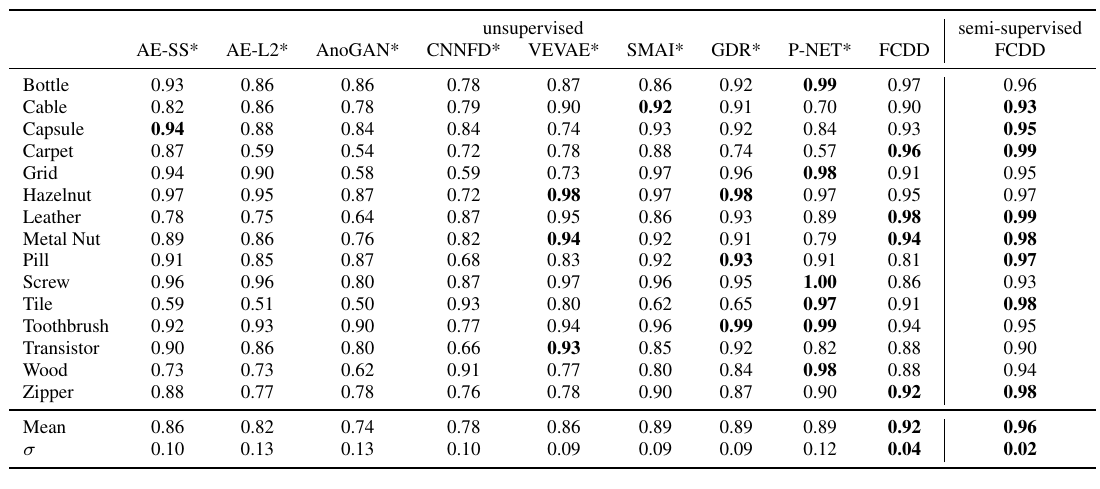

**post-note**: i moved the `.txt` below to `data` and renamed to correct the typo in "pape"

In [25]:
# ############ variable ############
txt_fifle = Path("./pape-table2-mvtec-perf.txt")  # contains the data part of the table above
str_data = txt_fifle.read_text()
nlines_per_group = 11


# ############ fixed ############
lines = str_data.strip().split("\n")
line_groups = [
    lines[(i * nlines_per_group):((i + 1) * nlines_per_group)] 
    for i in range(len(lines) // nlines_per_group)
]
line_groups = [
    {
        "normal_class_label": g[0].lower(),
        "unsupervised": 100 * float(g[-2]),
        "semi-supervised": 100 * float(g[-1]),
    }
    for g in line_groups
]
paper_df = pd.DataFrame.from_records(data=line_groups).set_index("normal_class_label")
# manual fix 
paper_df = paper_df.rename(index={"metal nut": "metal_nut", 'σ': "std"})
paper_df

,unsupervised,semi-supervised
normal_class_label,,
bottle,97.0,96.0
cable,90.0,93.0
capsule,93.0,95.0
carpet,96.0,99.0
grid,91.0,95.0
hazelnut,95.0,97.0
leather,98.0,99.0
metal_nut,94.0,98.0
pill,81.0,97.0


## my data

In [26]:
sup_rocauc_per_class.index.size

15

In [27]:
# are the rows (classes) in the same order?
unsup_rocauc_per_class.index == sup_rocauc_per_class.index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [28]:
unsup_rocauc_per_class
sup_rocauc_per_class

,sample_roc.auc,pixel_roc.auc
normal_class_label,,
bottle,99.190476,97.007996
cable,79.182909,90.547340
capsule,75.787794,93.026184
carpet,91.292135,96.445884
grid,76.675021,91.528274
hazelnut,94.828571,95.501949
leather,99.986413,98.353175
metal_nut,90.166178,93.993337
pill,76.088380,83.028246


,sample_roc.auc,pixel_roc.auc
normal_class_label,,
bottle,98.968254,96.686087
cable,90.067466,94.130515
capsule,91.200638,92.948803
carpet,96.869984,98.655946
grid,92.280702,95.204598
hazelnut,98.785714,97.118798
leather,99.993207,98.680869
metal_nut,92.521994,97.471466
pill,83.758865,96.755560


In [29]:
def rename_columns_add_prefix(df, prefix: str):
    return df.rename(
        columns={
            col: f"{prefix}{col}" 
            for col in df.columns
        }
    )

my_df = pd.concat(
    [
        rename_columns_add_prefix(unsup_rocauc_per_class, prefix="unsupervised."),
        rename_columns_add_prefix(sup_rocauc_per_class, prefix="semi-supervised."),
    ], 
    axis=1
)
my_df

,unsupervised.sample_roc.auc,unsupervised.pixel_roc.auc,semi-supervised.sample_roc.auc,semi-supervised.pixel_roc.auc
normal_class_label,,,,
bottle,99.190476,97.007996,98.968254,96.686087
cable,79.182909,90.547340,90.067466,94.130515
capsule,75.787794,93.026184,91.200638,92.948803
carpet,91.292135,96.445884,96.869984,98.655946
grid,76.675021,91.528274,92.280702,95.204598
hazelnut,94.828571,95.501949,98.785714,97.118798
leather,99.986413,98.353175,99.993207,98.680869
metal_nut,90.166178,93.993337,92.521994,97.471466
pill,76.088380,83.028246,83.758865,96.755560


## compare df

In [30]:
# get rid of sample-wise things because the paper doesnt havee it
my_df_pixelwise = my_df
my_df_pixelwise = my_df_pixelwise.drop(
    columns=[c for c in my_df.columns if "sample_roc" in c]
)
my_df_pixelwise = my_df_pixelwise.rename(
    columns={c: c.rstrip(".pixel_roc.auc") for c in my_df_pixelwise.columns}
)
my_df_pixelwise.loc["mean"] = my_df_pixelwise.mean(axis=0)
my_df_pixelwise.loc["std"] = my_df_pixelwise.std(axis=0)
my_df_pixelwise

,unsupervised,semi-supervised
normal_class_label,,
bottle,97.007996,96.686087
cable,90.547340,94.130515
capsule,93.026184,92.948803
carpet,96.445884,98.655946
grid,91.528274,95.204598
hazelnut,95.501949,97.118798
leather,98.353175,98.680869
metal_nut,93.993337,97.471466
pill,83.028246,96.755560


In [31]:
paper_df.index.size == my_df_pixelwise.index.size

True

In [32]:
paper_df.index == my_df_pixelwise.index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [33]:
# find index that doesnt correspond
bad_indices = (paper_df.index != my_df_pixelwise.index)
paper_df.index[bad_indices]

Index([], dtype='object', name='normal_class_label')

In [34]:
diff_df = my_df_pixelwise - paper_df
compare_df = pd.concat(
    [my_df_pixelwise, paper_df, diff_df, diff_df.abs()], 
    axis=1, 
    keys=("ours", "original", "diff", "absdiff")
)
compare_df = compare_df.swaplevel(i=0, j=1, axis='columns').sort_index(axis='columns', level=0)
compare_df.round(decimals=2)

semi-supervised                       unsupervised        \
                           absdiff  diff original   ours      absdiff  diff   
normal_class_label                                                            
bottle                        0.69  0.69     96.0  96.69         0.01  0.01   
cable                         1.13  1.13     93.0  94.13         0.55  0.55   
capsule                       2.05 -2.05     95.0  92.95         0.03  0.03   
carpet                        0.34 -0.34     99.0  98.66         0.45  0.45   
grid                          0.20  0.20     95.0  95.20         0.53  0.53   
hazelnut                      0.12  0.12     97.0  97.12         0.50  0.50   
leather                       0.32 -0.32     99.0  98.68         0.35  0.35   
metal_nut                     0.53 -0.53     98.0  97.47         0.01 -0.01   
pill                          0.24 -0.24     97.0  96.76         2.03  2.03   
screw                         0.87 -0.87     93.0  92.13         1.46  1.46   
tile                          0.49  0.49     98.0  98.49         0.44  0.44   
toothbrush                    0.28 -0.28     95.0  94.72         1.57 -1.57   
transistor                    1.27  1.27     90.0  91.27         0.36 -0.36   
wood                          1.98 -1.98     94.0  92.02         1.05 -1.05   
zipper                        0.05  0.05     98.0  98.05         0.20  0.20   
mean                          0.38 -0.38     96.0  95.62         0.16 -0.16   
std                           0.52  0.52      2.0   2.52         0.09  0.09   

                                    
                   original   ours  
normal_class_label                  
bottle                 97.0  97.01  
cable                  90.0  90.55  
capsule                93.0  93.03  
carpet                 96.0  96.45  
grid                   91.0  91.53  
hazelnut               95.0  95.50  
leather                98.0  98.35  
metal_nut              94.0  93.99  
pill                   81.0  83.03  
screw                  86.0  87.46  
tile                   91.0  91.44  
toothbrush             94.0  92.43  
transistor             88.0  87.64  
wood                   88.0  86.95  
zipper                 92.0  92.20  
mean                   92.0  91.84  
std                     4.0   4.09

In [35]:
compare_df.drop(index=["mean", "std"]).describe().round(decimals=2)

semi-supervised                        unsupervised                  \
              absdiff   diff original   ours      absdiff   diff original   
count           15.00  15.00    15.00  15.00        15.00  15.00    15.00   
mean             0.71  -0.18    95.80  95.62         0.64   0.24    91.60   
std              0.64   0.95     2.57   2.61         0.61   0.87     4.53   
min              0.05  -2.05    90.00  91.27         0.01  -1.57    81.00   
25%              0.26  -0.44    94.50  93.54         0.28   0.00    89.00   
50%              0.49  -0.24    96.00  96.69         0.45   0.35    92.00   
75%              1.00   0.35    98.00  97.76         0.80   0.52    94.50   
max              2.05   1.27    99.00  98.68         2.03   2.03    98.00   

              
        ours  
count  15.00  
mean   91.84  
std     4.23  
min    83.03  
25%    89.09  
50%    92.20  
75%    94.75  
max    98.35

In [36]:
compare_df["unsupervised"][["absdiff"]].sort_values("absdiff", ascending=False).T.round(decimals=2)

normal_class_label,pill,toothbrush,screw,wood,cable,grid,hazelnut,carpet,tile,transistor,leather,zipper,mean,std,capsule,bottle,metal_nut
absdiff,2.03,1.57,1.46,1.05,0.55,0.53,0.5,0.45,0.44,0.36,0.35,0.2,0.16,0.09,0.03,0.01,0.01


In [37]:
compare_df["semi-supervised"][["absdiff"]].sort_values("absdiff", ascending=False).T.round(decimals=2)

normal_class_label,capsule,wood,transistor,cable,screw,bottle,metal_nut,std,tile,mean,carpet,leather,toothbrush,pill,grid,hazelnut,zipper
absdiff,2.05,1.98,1.27,1.13,0.87,0.69,0.53,0.52,0.49,0.38,0.34,0.32,0.28,0.24,0.2,0.12,0.05


# training time

In [39]:
unsup_df.head(1)
sup_df.head(1)

,normal_class,it,normal_class_label,training_timedelta,sample_roc.tpr,sample_roc.fpr,sample_roc.ths,sample_roc.auc,pixel_roc.auc,key
normal_0.it_0,normal_0,it_0,bottle,0 days 00:59:24,"[0.0, 0.015873015873015872, 0.873015873015873,...","[0.0, 0.0, 0.0, 0.05, 0.05, 0.1, 0.1, 1.0]","[1.4232916235923767, 0.4232916235923767, 0.013...",0.992857,0.970053,normal_0.it_0


,normal_class,it,normal_class_label,training_timedelta,sample_roc.tpr,sample_roc.fpr,sample_roc.ths,sample_roc.auc,pixel_roc.auc,key
normal_0.it_0,normal_0,it_0,bottle,0 days 00:31:38,"[0.0, 0.015873015873015872, 0.9523809523809523...","[0.0, 0.0, 0.0, 0.05, 0.05, 0.15, 0.15, 0.65, ...","[1.990862250328064, 0.990862250328064, 0.01404...",0.986508,0.964563,normal_0.it_0


In [100]:
training_time_df = pd.concat(
    [
        df_[["normal_class_label", "it", "training_timedelta", "key"]]
        for df_ in [unsup_df, sup_df]
    ], 
    axis=0, 
    keys=("unsupervised", "semi-supervised")
).droplevel(1, axis=0)

training_time_df

,normal_class_label,it,training_timedelta,key
unsupervised,bottle,it_0,0 days 00:59:24,normal_0.it_0
unsupervised,bottle,it_1,0 days 01:17:01,normal_0.it_1
unsupervised,bottle,it_2,0 days 01:20:52,normal_0.it_2
unsupervised,bottle,it_3,0 days 01:23:04,normal_0.it_3
unsupervised,bottle,it_4,0 days 01:16:43,normal_0.it_4
...,...,...,...,...
semi-supervised,screw,it_0,0 days 00:47:12,normal_9.it_0
semi-supervised,screw,it_1,0 days 00:45:02,normal_9.it_1
semi-supervised,screw,it_2,0 days 00:43:23,normal_9.it_2
semi-supervised,screw,it_3,0 days 00:46:02,normal_9.it_3


## unsupervised

In [101]:
train_df = training_time_df.loc["unsupervised"]

import numpy as np
# timedelta needs to be converted to int64 so one can compute std
# src: https://stackoverflow.com/a/44616595/9582881
train_df["tmp"] = train_df["training_timedelta"].values.astype(np.int64)
class_means = train_df.groupby("normal_class_label").agg({"tmp": ["mean", "std"]}).droplevel(0, axis='columns')
class_means["mean"] = pd.to_timedelta(class_means["mean"]).round("1s")
class_means["std"] = pd.to_timedelta(class_means["std"]).round("1s")

class_means.sort_values(by="mean", ascending=False)
class_means.describe()

del train_df, class_means

/tmp/ipykernel_8043/3666431575.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["tmp"] = train_df["training_timedelta"].values.astype(np.int64)


,mean,std
normal_class_label,,
carpet,0 days 05:33:37,0 days 09:16:56
hazelnut,0 days 01:56:54,0 days 00:08:37
pill,0 days 01:26:42,0 days 00:02:44
screw,0 days 01:23:33,0 days 00:01:28
leather,0 days 01:19:07,0 days 00:05:25
bottle,0 days 01:15:25,0 days 00:09:20
wood,0 days 01:14:24,0 days 00:04:15
metal_nut,0 days 01:12:21,0 days 00:01:47
zipper,0 days 01:11:25,0 days 00:07:45


,mean,std
count,15,15
mean,0 days 01:30:06.066666666,0 days 00:40:51.600000
std,0 days 01:09:59.756497476,0 days 02:22:47.506786857
min,0 days 00:22:38,0 days 00:01:17
25%,0 days 01:09:28.500000,0 days 00:02:11
50%,0 days 01:12:21,0 days 00:03:09
75%,0 days 01:21:20,0 days 00:06:35
max,0 days 05:33:37,0 days 09:16:56


there must be an outlier with carpet because its std is too high

In [102]:
training_time_df.loc["unsupervised"].set_index("normal_class_label").loc["carpet"]

,it,training_timedelta,key
normal_class_label,,,
carpet,it_0,0 days 22:09:51,normal_3.it_0
carpet,it_1,0 days 01:18:27,normal_3.it_1
carpet,it_2,0 days 01:22:18,normal_3.it_2
carpet,it_3,0 days 01:32:51,normal_3.it_3
carpet,it_4,0 days 01:24:39,normal_3.it_4


the cell below removes the outlier of 22h

In [111]:
train_df = training_time_df.loc["unsupervised"]

# ############ custom part ###############
# remove an outlier
train_df = train_df.set_index("key").drop("normal_3.it_0").set_index("normal_class_label")
# ############ custom part ###############

import numpy as np
# timedelta needs to be converted to int64 so one can compute std
# src: https://stackoverflow.com/a/44616595/9582881
train_df["tmp"] = train_df["training_timedelta"].values.astype(np.int64)
class_means = train_df.groupby("normal_class_label").agg({"tmp": ["mean", "std"]}).droplevel(0, axis='columns')
class_means["mean"] = pd.to_timedelta(class_means["mean"]).round("1s")
class_means["std"] = pd.to_timedelta(class_means["std"]).round("1s")

class_means.sort_values(by="mean", ascending=False)
class_means.describe()

del train_df, class_means

,mean,std
normal_class_label,,
hazelnut,0 days 01:56:54,0 days 00:08:37
pill,0 days 01:26:42,0 days 00:02:44
carpet,0 days 01:24:34,0 days 00:06:05
screw,0 days 01:23:33,0 days 00:01:28
leather,0 days 01:19:07,0 days 00:05:25
bottle,0 days 01:15:25,0 days 00:09:20
wood,0 days 01:14:24,0 days 00:04:15
metal_nut,0 days 01:12:21,0 days 00:01:47
zipper,0 days 01:11:25,0 days 00:07:45


,mean,std
count,15,15
mean,0 days 01:13:29.866666666,0 days 00:04:08.200000
std,0 days 00:19:14.990529748,0 days 00:02:41.615593307
min,0 days 00:22:38,0 days 00:01:17
25%,0 days 01:09:28.500000,0 days 00:02:11
50%,0 days 01:12:21,0 days 00:03:09
75%,0 days 01:21:20,0 days 00:05:45
max,0 days 01:56:54,0 days 00:09:20


## semi-supervised

In [112]:
train_df = training_time_df.loc["semi-supervised"]

import numpy as np
# timedelta needs to be converted to int64 so one can compute std
# src: https://stackoverflow.com/a/44616595/9582881
train_df["tmp"] = train_df["training_timedelta"].values.astype(np.int64)
class_means = train_df.groupby("normal_class_label").agg({"tmp": ["mean", "std"]}).droplevel(0, axis='columns')
class_means["mean"] = pd.to_timedelta(class_means["mean"]).round("1s")
class_means["std"] = pd.to_timedelta(class_means["std"]).round("1s")

class_means.sort_values(by="mean", ascending=False)
class_means.describe()

del train_df, class_means

/tmp/ipykernel_8043/3285780723.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["tmp"] = train_df["training_timedelta"].values.astype(np.int64)


,mean,std
normal_class_label,,
hazelnut,0 days 01:00:06,0 days 00:02:37
wood,0 days 00:49:39,0 days 00:04:22
zipper,0 days 00:47:44,0 days 00:04:47
pill,0 days 00:45:58,0 days 00:06:32
screw,0 days 00:45:06,0 days 00:01:33
transistor,0 days 00:43:50,0 days 00:04:36
carpet,0 days 00:42:32,0 days 00:01:44
cable,0 days 00:40:56,0 days 00:03:29
leather,0 days 00:40:45,0 days 00:02:22


,mean,std
count,15,15
mean,0 days 00:41:28.866666666,0 days 00:03:11.133333333
std,0 days 00:09:17.435052804,0 days 00:01:32.366402879
min,0 days 00:15:59,0 days 00:01:15
25%,0 days 00:37:53.500000,0 days 00:01:51.500000
50%,0 days 00:40:56,0 days 00:02:55
75%,0 days 00:45:32,0 days 00:04:29
max,0 days 01:00:06,0 days 00:06:32
